# Dog or Not
*A comprehensive classifier analysis on the association of vendor names with its description*

**by Zaki Aslam, Hector Palafox Prieto, Jennifer Tsang, and Samrawit Mezgebo Tsegay**

In [1]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, cross_validate,
    cross_val_predict, RandomizedSearchCV
)
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform, randint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mglearn.tools import visualize_coefficients

# Summary

In this project, we used decision trees, logistic regression, and a Naive Bayes classifier to identify whether or not a food vendor sells hot dogs via their name. We trained each model individually using a cross-validation setup, and we compared the scores of the accuracy in order to determine a model to train and to compare to the test data. The model we chose, finally, was the Naive Bayes, as it provided a slightly better score and less underfit and overfit than the other models present. Finally, we validated it with our test data and came to the conclusion that even though it is good enough for classifying most of the cases, it still struggles discerning from the minority class, which in our case, is our target.

# Introduction

Food trucks and mobile food vendors are a common sight in Downtown Vancouver, offering a wide range of cuisine types from hot dogs and burgers to shawarma and tacos. With so many different vendors and food options, it can be useful to automatically identify what kind of food a vendor specializes in based only on select information. In this project, we study whether we can predict if a food vendor is a hot dog vendor or not using the vendor’s business name. We used a publicly available dataset of mobile food vendors in Vancouver from the City of Vancouver’s open data portal, where each row represents relevant information for a single food vendor and includes columns such as BUSINESS_NAME, LOCATION, DESCRIPTION, GEO_LOCALAREA, and geographic coordinates. For our analysis, we constructed a binary target variable named is_hotdog, which is True when the DESCRIPTION is “Hot Dogs” and False otherwise. This allows us to investigate how much information about the type of food a vendor sells can be extracted from the business name, as well as putting to test the prediction power of some of the most common classification algorithms: Decision Trees, Logistic Regression, and Naïve-Bayes.

# Methods & Results

## Data

We are using the data directly from the Vancouver City hall portal, yet an offline copy is present on the `data` directory, retrieved on **2025-11-17**.

- **KEY** (`str`): A unique identifier of the vendor
- **VENDOR_TYPE** (`str`): The type of vendor for that specific location (in our case all of them are vendor_food)
- **STATUS** (`str`): Whether or not the vendor remains open or not (in our case all of them are open)
- **BUSINESS_NAME** (`str`): The name of the vendor
- **LOCATION** (`str`): Address of the vendor
- **DESCRIPTION** (`str`): The category of food offered by the vendor
- **GEO_LOCALAREA** (`str`): The zone/area of the city in which the vendor is located
- **Geom** (`dict`): The coordinates stored as a JSON object
- **geo_point_2d** (`2d_array`): The coordinates stored as a 2D array


In [2]:
# loads data from the original source on the web
url = (
    "https://opendata.vancouver.ca/api/explore/v2.1/"
    "catalog/datasets/food-vendors/exports/"
    "csv?lang=en&timezone=America%2FLos_Angeles"
    "&use_labels=true&delimiter=%3B"
)
food_vendors = pd.read_csv(url, sep = ";")

food_vendors.head(5)

,KEY,VENDOR_TYPE,STATUS,BUSINESS_NAME,LOCATION,DESCRIPTION,GEO_LOCALAREA,Geom,geo_point_2d
0,DT21,vendor_food,open,NaN,South Side of 300 Davie St - 6 Metres East of ...,Hot Dogs,Downtown,"{""coordinates"": [-123.122779848109, 49.2747502...","49.2747502296, -123.122779848"
1,C12,vendor_food,open,Chickpea,Authorised Parking Meter - North Side of W Cor...,Vegetarian,Downtown,"{""coordinates"": [-123.115773447168, 49.2876125...","49.2876125304, -123.115773447"
2,GT02,vendor_food,open,Chou Chou Crepes,North Side of 100 Water St - 10 Metres West of...,French Crepes,Downtown,"{""coordinates"": [-123.106627254804, 49.2839897...","49.283989749, -123.106627255"
3,DT75,vendor_food,open,Eat Chicken Wraps,South Side of 800 Robson St - 28 Metres East o...,Wraps and Sandwiches,Downtown,"{""coordinates"": [-123.121388, 49.282313], ""typ...","49.282313, -123.121388"
4,DT26,vendor_food,open,Japadog,East Side of 500 Burrard St - 6 Metres South o...,Hot Dogs,Downtown,"{""coordinates"": [-123.117884, 49.286363], ""typ...","49.286363, -123.117884"


<p style="text-align: center"><small>Table 1: Raw data from web source</small></p>

## Analysis

The motivation for our analysis is mainly understand the prediction power of the name of the vendor in identifying what they sell. In our case, we chose Hot Dogs, since in the preview of our data, we saw several instances of this category showing up.

### Preparing the data for the analysis

Here we will be removing any column, except for the name and description. Then, we will add a category that states whether or not the vendors sell Hot Dogs or not.

In [3]:
# data wrangling and cleaning

# dropping irrelevant columns
clean_food = food_vendors.drop(columns=[
    'KEY', 'VENDOR_TYPE', 'STATUS', 'LOCATION',
    'GEO_LOCALAREA', 'Geom', 'geo_point_2d'
])

clean_food["is_hotdog"] = clean_food["DESCRIPTION"] == "Hot Dogs"
clean_food["BUSINESS_NAME"] = clean_food["BUSINESS_NAME"].fillna("")

clean_food.head()

,BUSINESS_NAME,DESCRIPTION,is_hotdog
0,,Hot Dogs,True
1,Chickpea,Vegetarian,False
2,Chou Chou Crepes,French Crepes,False
3,Eat Chicken Wraps,Wraps and Sandwiches,False
4,Japadog,Hot Dogs,True


<p style="text-align: center"><small>Table 2: Processed data from web source</small></p>

With this, we can split our data into training and testing.

We chose a 70% split since our data set is small, and we do not want to risk underfitting on the test data.

We also set `random_state=522` to establish reproducibility for this analysis.

In [4]:
# create train and test split

train_data, test_data = train_test_split(
    clean_food, train_size=0.7, random_state=522
)


### Exploratory Data Analysis (EDA)

Given that we are interested in solely the classification power of the name, we will be taking a look more into the classes present into our training set.

First, we will take a look at the DESCRIPTION category distribution:

In [5]:
# Data visualization for EDA
# Code in this cell adapted from DSCI 351 Lecture 2 and 5 
# color names supported for the bar charts located at: https://www.w3schools.com/cssref/css_colors.php


plot1 = (alt.Chart(
    train_data,
    title="What are the most common cuisine types among food vendors in Downtown Vancouver?"
).mark_bar
    (color="chocolate").encode(
        x=alt.X("count()", title="Total"),
        y=alt.Y("DESCRIPTION:N", sort='-x', title="Food type")
    ).properties(
        width=250,
        height=500
    )
)

plot1

alt.Chart(...)

<p style="text-align: center"><small>Fig. 1: Most common cuisine types among food vendors in Downtown Vancouver</small></p>

As we can see, `Hot Dogs` are the most popular class in our data set, where can observe that the rest of our categories are pulverised into several other classifications with one or 2 observations. Thus, making our classifier identify the most popular one, might be a way to improve model performance.

Nonetheless, being the most popular class, does not mean that there could not be class imbalance. We will observe if this is true in the next plot:

In [6]:
plot2 = (alt.Chart(
    train_data,
    title="Are we dealing with a class imbalance in our train data?"
).mark_bar(color="seagreen").encode(
    x=alt.X("is_hotdog", title="Is it a hot dog vendor?"),
    y=alt.Y("count()", title="Number of vendors")
).properties(
        width=85,
        height=495
    )
        )

plot2

alt.Chart(...)

<p style="text-align: center"><small>Fig. 2: Class imbalance in training data</small></p>

As we can see, even being the most popular class, there distribution is biased towards more non-hot-dog vendors (which we saw before that are not concentrated in a particular competing class).

Lastly, we noticed that there were some initial blanks in the `BUSINESS_NAME` which we addressed by changing it to an empty space (and thus not screwing up the `CountVectorizer` instance we will need for this analysis). It would be interesting to see if there is a discernible pattern of this, against the target:

In [7]:
# summary EDA, identify missing and NAN values

train_data["text_is_na"] = train_data["BUSINESS_NAME"] == ""

plot3 = (alt.Chart(
    train_data,
    title="Are blank names relevant for our classification?"
).mark_rect(color="seagreen").encode(
    x=alt.X("is_hotdog", title="Is it a hot dog vendor?"),
    y=alt.Y("text_is_na", title="Is it a blank BUSINESS_NAME?"),
    color=alt.Color("count()", title="# of observations")
).properties(
        width=200,
        height=200
    )
)

plot3 = plot3 + alt.Chart(train_data).mark_text(
    fontSize=14,
    fontWeight="bold"
).encode(
    x="is_hotdog:N",
    y="text_is_na:N",
    text=alt.Text("count():Q", format="d")
)

plot3

alt.LayerChart(...)

<p style="text-align: center"><small>Fig. 3: Blank names relevance in classification</small></p>

We can observe here that all the cases of a blank `BUSINESS_NAME` are belong to Hot Dog vendors, which would be something we would like our models to capture.

In summary, when visualizing our EDA we can notice several key points. In the first plot we can see that of all the cuisine types from Downtown Vancouver food vendors, hot dog stands seem to be the most common of them all. It is also very important to analyze our classes before starting our work. When you have a large class imbalance, a lot of the times your model will give you a score that is not representative of whether or not your model works well. For example, if you observe the second plot for a data set where one class is represented in a much higher proportion than the other, a model like DummyClassifier will give you an extremely high score. This isn't because the model works perfectly it's because it'll always predict the higher represented class! Yet we can see that we do not have that issue as much here as the class imbalance isn't too skewed. Finally, we would expect for our classifier to be able to identify the "easy" base case of having no name, since this is a relevant discriminator for both our classes.

### Methodology

For this analysis we will implement a `CountVectorizer` object to create a bag of words (BOW). This method will split each individual word in the names of the businesses into its own individual columns, and will assess whether or not the word is present in the data set.

We will then pass this `CountVectorizer` into a pipeline with the different models we want to test:
- `DummyClassifier`: This will be our baseline to check on how we will predict whether or not the vendor sells hot dogs or not.
- `DecisionTreeClassifier`: This simple model will help us identify if simple decisions map out the relationship of the names to the category.
- `LogisticRegression`: This model will help us identify if there are linear relationships in the model, and which tokens are more relevant for our classification.
- `BernoulliNB` (Naïve-Bayes): This model is quick to fit and train, and uses a probabilistic approach to the classification, and it would be interesting to see how it fares in comparison to the rest of them.

After performing the evaluation for each model, we will compare them all together and train the best one, optimising its hyperparameters. We will score based on the model **accuracy** (correct predictions over total predictions), as this is just a simple experiment to validate the relationship of these 2 variables.

With the best model, we will take a peek on how it performs on the test data, and evaluate our conclusions.

### Helper Functions

These are some auxiliary methods to improve the readability of the analysis.

In [8]:
## This is to create the pipelines with the count vectorizer
## Note that we did not set "stop_words" as the filler words may
## be a relevant element of the title. Yet we will establish to 
## only check for whether the word appears or not in the set.
## (binary=True)
def build_pipeline(model):
    return make_pipeline(
        CountVectorizer(binary=True),
        model
    )

## Here we will store our model cross-validation (CV) results
model_comparison = dict()

## This is to perform the CV and store it for future comparison
def add_to_model_comparison(model_name, model):
    model_comparison[model_name] = pd.DataFrame(
        cross_validate(
            model,
            X_train,
            y_train,
            cv=5,
            return_train_score=True,
        )
    ).agg(['mean', 'std']).round(3).T

## This performs the CV  and displays scores
def show_cv_scores(model):
    return pd.DataFrame(
        cross_validate(
            model,
            X_train,
            y_train,
            cv=5,
            return_train_score=True,
        )
    )

## This performs the CV, stores the results and displays them
def record_and_display_cv_scores(model_name, model):
    cv_results = pd.DataFrame(
        cross_validate(
            model,
            X_train,
            y_train,
            cv=5,
            return_train_score=True,
        )
    )
    model_comparison[model_name] = cv_results.agg(
        ['mean', 'std']
    ).round(3).T
    return cv_results

## This concatenates the results and displays them in a formatted table
def compare_models(param='mean'):
    return pd.concat(
        model_comparison,
        axis='columns'
    ).xs(
        param,
        axis='columns',
        level=1
    ).style.format(
        precision=2
    ).background_gradient(
        axis=None
    )

## This displays the model mismatches for CV training or Test data after training
def display_model_mistmatches(model, train=True):
    if train:
        data_dict = {
            "y": y_train,
            "y_hat": cross_val_predict(
                model,
                X_train,
                y_train
            ).tolist(),
            "x": X_train.tolist(),
            "probabilities": cross_val_predict(
                model,
                X_train,
                y_train,
                method="predict_proba"
            ).tolist(),
        }
    else:
        data_dict = {
            "y": y_test,
            "y_hat": model.predict(X_test),
            "x": X_test.tolist(),
            "probabilities": model.predict_proba(X_test).tolist(),
        }
    
    df = pd.DataFrame(data_dict)
    return df[df["y"] != df["y_hat"]].sort_values('probabilities')


## This displays the confusion matrix for CV training 
## or Test data after training
def display_confusion_matrix(model, train=True):
    if train:
        ConfusionMatrixDisplay.from_predictions(
            y_train,
            cross_val_predict(
                model,
                X_train,
                y_train
            )
        )
    else:
        ConfusionMatrixDisplay.from_predictions(
            y_test,
            model.predict(X_test)
        )
    

### Data Split

We will perform the preparation of our data for the analysis, as well as getting some relevant features out of it.

In [9]:
## Here we are splitting our data into inputs and responses

X_train = train_data["BUSINESS_NAME"]
y_train = train_data["is_hotdog"]

X_test = test_data["BUSINESS_NAME"]
y_test = test_data["is_hotdog"]

One relevant element to observe is our vocabulary. We will extract how many words in total we can use, as well as some of them:

In [10]:
## Here we are obtaining the vocabulary of our BOW.

bag_of_words = make_pipeline(CountVectorizer(binary=True))
bag_of_words.fit(X_train, y_train)
vocab = (
    bag_of_words.named_steps["countvectorizer"].get_feature_names_out()
)

## Display the first 5 tokens

print("The vocabulary size is:", len(vocab))
pd.DataFrame({"words": vocab}).head()

The vocabulary size is: 90


,words
0,actual
1,ali
2,aussie
3,bandidas
4,bbq


<p style="text-align: center"><small>Table 3: First 5 elements of the vocabulary.</small></p>

We will also take a look at the proportions of our target variable in the training and test sets.

In [11]:
# look at the proportion of each class for train and test data

data_proportion = pd.DataFrame({
    "train": y_train.value_counts(normalize=True),
    "test": y_test.value_counts(normalize=True)
})

data_proportion

,train,test
is_hotdog,,
False,0.68254,0.607143
True,0.31746,0.392857


<p style="text-align: center"><small>Table 4: Train and test proportions of the target class.</small></p>


For all our models, a `True` prediction will mean that the vendor is a Hot Dog seller, and `False` the other way around.

As mentioned before, we can observe that the data is relatively balanced in both sets: being around **34%** of our total data. Yet the target class is less prominent in our test split. Nonetheless, we will not balance the data set, as  this is something we can consider for a future iteration of this analysis.

### Baseline (`DummyClassifier`)

Thus we will be defining a dummy classifier to have a reference to compare our different models. For this and all our models we will use 5 folds.

In [12]:
# DummyClassifier as baseline

dummy = DummyClassifier()

record_and_display_cv_scores("Baseline", dummy)

,fit_time,score_time,test_score,train_score
0,0.008356,0.002276,0.692308,0.680000
1,0.005937,0.000000,0.692308,0.680000
2,0.000000,0.000000,0.692308,0.680000
3,0.000000,0.000000,0.666667,0.686275
4,0.000000,0.000000,0.666667,0.686275


<p style="text-align: center"><small>Table 5: DummyClassifier cross validation scores and times.</small></p>


As expected, the dummy consistently predicts the majority class, with accuracy of around **0.63**, being consistent with the representation of our split.

### Decision Tree

Here we are training a simple decision tree to identify whether the vendor sells hot dogs or not. This is a simple model with easy to interpret coefficients, and it would be interesting checking whether or not it correctly identified some of the most relevant clues (something like "Joe's Hot Dogs" being correctly classified, for instance).

#### Cross Validation

In [13]:
tree = build_pipeline(DecisionTreeClassifier(random_state=522))

record_and_display_cv_scores("Decision Tree",  tree)

,fit_time,score_time,test_score,train_score
0,0.004902,0.0,0.615385,0.980000
1,0.004330,0.0,0.538462,1.000000
2,0.005445,0.0,0.384615,0.980000
3,0.010958,0.0,0.500000,0.980392
4,0.000000,0.0,0.666667,0.980392


<p style="text-align: center"><small>Table 6: Decision tree cross validation scores and times.</small></p>


The tree performs worse than the dummy classifier, as it is overfitting the prediction, which is evident in the substantial gap between the validation and training scores (around **-0.65** difference for all folds).

#### Model Parameters

We can take a look at the depths and tree structure to better understand these discrepancies:

In [14]:
tree.fit(X_train, y_train)

print(
    "The max depth of the tree is:",
    tree["decisiontreeclassifier"].tree_.max_depth
)

The max depth of the tree is: 32


As we can see, the model contains 32 levels of decisions, yet, the level of specificity (given that we are using a bag of words) makes it perform poorly. Here we can see the most discriminating factors:

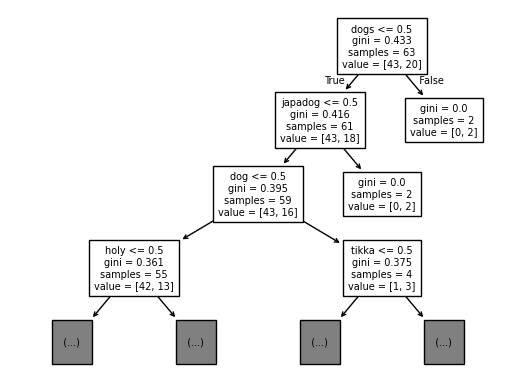

In [15]:
plot_tree(
    tree["decisiontreeclassifier"],
    feature_names=vocab,
    max_depth=3,
    fontsize=7
)
plt.show()

<p style="text-align: center"><small>Fig. 4: Decision tree structure (limited to the first 5 levels of the depth)</small></p>


We can observe some sensible initial discriminations, such as "dogs", "japadog" and "dog", which would quickly identify the vendor as a Hot Dog place.

#### Performance Metrics

Here we can observe the confussion metrics and misses in the cross validation of the model trained.

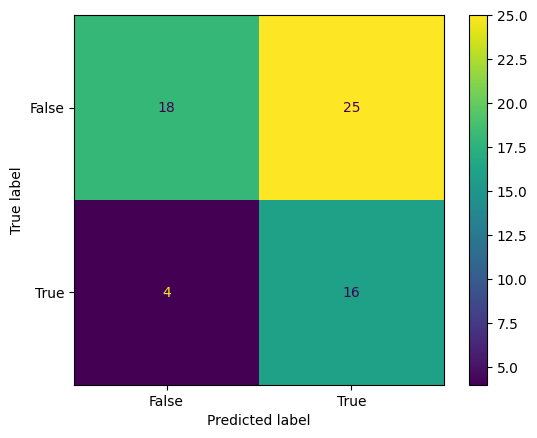

In [16]:
display_confusion_matrix(tree)

<p style="text-align: center"><small>Fig. 5: Confusion matrix for the Decision Tree.</small></p>


We can observe that the model is very good at identifying when something seems "Hot-Doggy", yet, it produces a high degree of false positives.

We can observe some of the mistakes below:

In [17]:
display_model_mistmatches(tree)

,y,y_hat,x,probabilities
39,False,True,Aussie Pie Guy,"[0.0, 1.0]"
1,False,True,Chickpea,"[0.0, 1.0]"
18,False,True,Cazba Express,"[0.0, 1.0]"
72,False,True,Dim Sum Express,"[0.0, 1.0]"
61,False,True,Mum's Grilled Cheese Truck,"[0.0, 1.0]"
81,False,True,Fat Duck Mobile Eatery,"[0.0, 1.0]"
54,False,True,Brasilian Roots,"[0.0, 1.0]"
35,False,True,Tacofino,"[0.0, 1.0]"
14,False,True,San Juan Family Farm,"[0.0, 1.0]"
56,False,True,Disco Cheetah,"[0.0, 1.0]"


<p style="text-align: center"><small>Table 7: Mismatches for Decision Tree.</small></p>


"Van Dog" seems to be a common occurrence, and this may have to do with the fact that it contains one of the "obvious" determinants, when it really is classified as something else.

### Logistic Regression

Here we will train a logistic regression in order to see whether or not we can improve our accuracy and reduce the possible overfitting. This model also has the advantage of having interpretable parameters, which in our case relate how often each of our features is associated with the target variable (`is_hotdog = True`).

#### Cross Validation

In [18]:
lr = build_pipeline(LogisticRegression(random_state=522))

record_and_display_cv_scores("Logistic Regression", lr)

,fit_time,score_time,test_score,train_score
0,0.016127,0.004315,0.692308,0.800000
1,0.016068,0.000000,0.615385,0.860000
2,0.010272,0.000000,0.692308,0.800000
3,0.010831,0.000000,0.750000,0.843137
4,0.008148,0.008316,0.666667,0.803922


<p style="text-align: center"><small>Table 8: Logistic regression cross validation scores and times.</small></p>


We can see a slight improvement in generalisation from the decision tree, but it performs almost as the dummy regressor. This could indicate that there may not be a single independent linear relationship in the token features to the target.

#### Model Parameters

We can take a look at the coefficients associated with each word and see which ones are the most relevant:

In [19]:
lr.fit(X_train, y_train)

print(
    "Number of coefficients: ",
    len(lr["logisticregression"].coef_[0]),
)

Number of coefficients:  90


In [20]:
lr_coefficients = pd.DataFrame({
    "token": vocab,
    "coefficient": lr["logisticregression"].coef_[0]
})
print(
    "The intercept is:",
    lr["logisticregression"].intercept_[0]
)
lr_coefficients

The intercept is: -0.4212868043303658


,token,coefficient
0,actual,-0.274768
1,ali,0.301589
2,aussie,-0.241342
3,bandidas,-0.322188
4,bbq,0.404270
...,...,...
85,tornado,-0.274768
86,truck,-0.424537
87,tube,0.477957
88,van,0.232173


<p style="text-align: center"><small>Table 9: Coefficients of the logistic regression.</small></p>


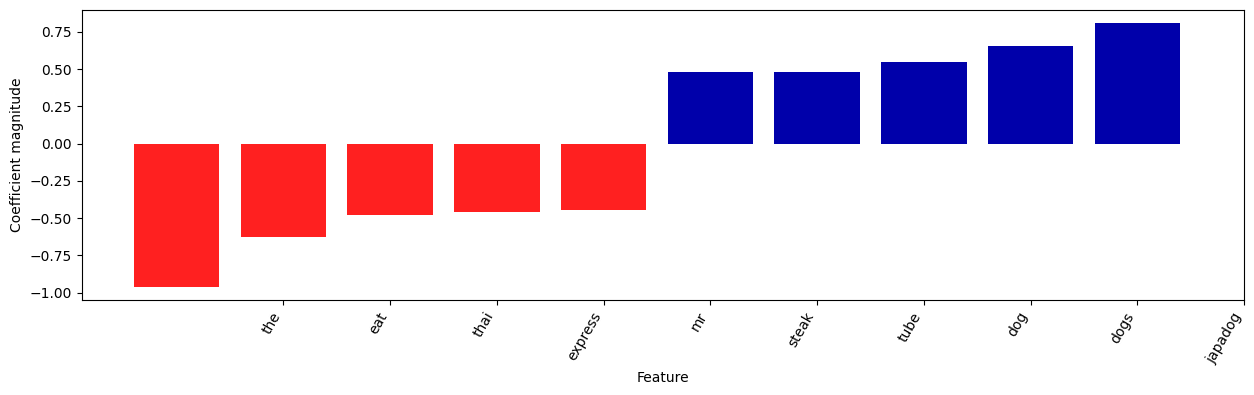

In [21]:
visualize_coefficients(
    lr_coefficients['coefficient'].to_numpy(),
    vocab,
    n_top_features=5
)

<p style="text-align: center"><small>Fig. 6: Top 5 most discriminant features (upper and lower).</small></p>


We can observe that the coefficients associated roughly match with the choices determined by the decision tree, with "japadog", "dog", and "dogs" being relevant.

Yet if we observe the intercept, we see the model is heavily biased into making a negative prediction. Thus, we would not expect the model being good in identifying hot dog places in particular.

#### Performance Metrics

Here we can observe the confusion metrics and misses in the cross validation of the model.

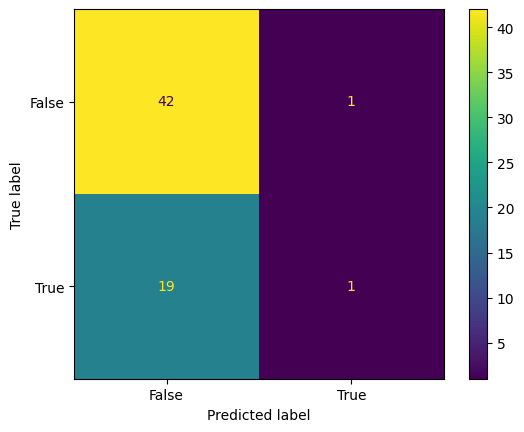

In [22]:
display_confusion_matrix(lr)

<p style="text-align: center"><small>Fig. 7: Confusion matrix for the Logistic Regression.</small></p>


We can observe that the logistic regression is not particularly good at discriminating, since it is evidently favouring the "not hot dog" class, as we expected from the coefficients calculated.

We can also see the patterns for the mismatches:

In [23]:
display_model_mistmatches(lr)

,y,y_hat,x,probabilities
88,False,True,Van Dog,"[0.2753287127132429, 0.7246712872867571]"
76,True,False,Japadog,"[0.5006669195189215, 0.4993330804810785]"
71,True,False,Ali's Hot Dogs,"[0.5013606160123325, 0.4986393839876675]"
26,True,False,Van Dog,"[0.5120621083657654, 0.4879378916342346]"
8,True,False,Sea Dogs,"[0.5232174481852025, 0.47678255181479745]"
87,True,False,Van Dog,"[0.5422916102554801, 0.4577083897445199]"
43,True,False,Tandoori Tikka Dog,"[0.5634667774972628, 0.43653322250273713]"
64,True,False,,"[0.584413055935707, 0.415586944064293]"
15,True,False,,"[0.6007844887270946, 0.3992155112729054]"
37,True,False,,"[0.6007844887270946, 0.3992155112729054]"


<p style="text-align: center"><small>Table 10: Mismatches for Logistic Regression.</small></p>


We can see the model failed identifying some of the "easy" catches we found previously, such as identifying blanks or keywords like "dog" which do not skew the balance enough in favour of the target class.

### Naïve Bayes

Finally we will be testing the Naïve-Bayes model, which is also a relatively simple model that also does not tend to over-fit as much, just to see which model is best.

#### Cross Validation

In [24]:
naive_bayes = build_pipeline(BernoulliNB())

record_and_display_cv_scores("Naïve-Bayes", naive_bayes)

,fit_time,score_time,test_score,train_score
0,0.006080,0.005543,0.692308,0.800000
1,0.000000,0.012466,0.615385,0.860000
2,0.007706,0.000000,0.769231,0.800000
3,0.007148,0.000000,0.666667,0.823529
4,0.000000,0.010239,0.750000,0.803922


<p style="text-align: center"><small>Table 11: Naïve-Bayes cross validation scores and times.</small></p>


We can also see that it performs better than the tree and dummy with less overfit, although not very consistently, like the logistic regression.

#### Performance Metrics

Here we can observe the confusion metrics and misses in the cross validation of the model trained.

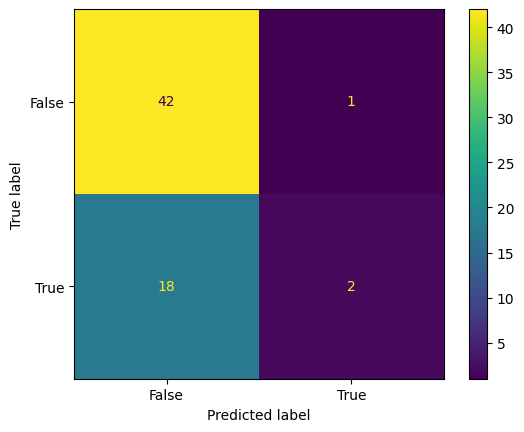

In [25]:
display_confusion_matrix(naive_bayes)

<p style="text-align: center"><small>Fig. 8: Confusion matrix for the Naïve-Bayes classifier</small></p>


It performs relatively similar to the logistic regression, as we can see is not particularly good at identifying hot dog features.

We can also see its mismatches:

In [26]:
display_model_mistmatches(naive_bayes)

,y,y_hat,x,probabilities
88,False,True,Van Dog,"[0.06050062302204834, 0.939499376977951]"
71,True,False,Ali's Hot Dogs,"[0.5074732507719065, 0.4925267492280938]"
8,True,False,Sea Dogs,"[0.5249735704987606, 0.47502642950123913]"
76,True,False,Japadog,"[0.5490536607569662, 0.45094633924303357]"
4,True,False,Japadog,"[0.5848871945740672, 0.4151128054259325]"
43,True,False,Tandoori Tikka Dog,"[0.5944219778373883, 0.40557802216261163]"
64,True,False,,"[0.7569533092725569, 0.24304669072744334]"
37,True,False,,"[0.8184381926941111, 0.18156180730588928]"
50,True,False,,"[0.8184381926941111, 0.18156180730588928]"
15,True,False,,"[0.8184381926941111, 0.18156180730588928]"


<p style="text-align: center"><small>Table 12: Mismatches for Naïve-Bayes.</small></p>


We see a similar pattern as the logistic regression, failing to identify the "obvious" patterns we stated in the beginning. 

### Model Comparisons

Knowing this, we can compare their scores to determine the model to train.



In [27]:
compare_models()

,Baseline,Decision Tree,Logistic Regression,Naïve-Bayes
fit_time,0.00,0.01,0.01,0.00
score_time,0.00,0.00,0.00,0.01
test_score,0.68,0.54,0.68,0.70
train_score,0.68,0.98,0.82,0.82


<p style="text-align: center"><small>Table 13: Comparisons of mean values of scores and times for all models.</small></p>


We can see a (really minuscule) difference between Naïve-Bayes and LR. Yet it is almost negligible. It could be purely by chance that we are observing the difference. Yet, to be consistent with our results, we will proceed to train the Naïve Bayes, as it showed the least amount of under and overfitting from the proposed models.

### Best Model Hyperparameter Optimisation

Here we will perform the optimisation of our model. Given that we chose the Naïve-Bayes estimator, we will optimise the `alpha` hyperparameter (which controls the tradeoff between variance and bias of our model), as well as the `max_features` variable (the actual size of our vocabulary considering the top `max_features` words) of our `CountVectorizer`, as this can also play a role in overfitting.

We are using a randomised approach to test in a wide space, with 500 iterations and a random integer ranging from $[5, \text{size of the vocabulary}]$ for `max_features`, and a loguniform distribution ranging from $[0.001, 1000]$ for `alpha`.

After this, we will use the best parameters obtained, and train our best model.

In [28]:
param_grid = {
    "countvectorizer__max_features": randint(5, len(vocab)),
    "bernoullinb__alpha": loguniform(1e-2, 1e2),
}

random_search = RandomizedSearchCV(
    naive_bayes,
    param_distributions=param_grid,
    n_iter=500,
    n_jobs=-1,
    return_train_score=True,
)

random_search.fit(X_train, y_train)

print(
    "Random Search best model score: \t %0.3f"
    % random_search.best_score_
)
print(
    "Random Search best max_features: \t %0.3f"
    % random_search.best_params_["countvectorizer__max_features"]
)
print(
    "Random Search best alpha: \t\t %0.3f"
    % random_search.best_params_["bernoullinb__alpha"]
)

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_countvectorizer__max_features",
        "param_bernoullinb__alpha",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().head()


Random Search best model score: 	 0.778
Random Search best max_features: 	 74.000
Random Search best alpha: 		 0.742


,mean_test_score,param_countvectorizer__max_features,param_bernoullinb__alpha,mean_fit_time
rank_test_score,,,,
1,0.778205,54,0.528735,0.024070
1,0.778205,71,0.492668,0.011411
1,0.778205,42,0.578830,0.011728
1,0.778205,48,0.776196,0.026230
1,0.778205,54,0.882626,0.021615


<p style="text-align: center"><small>Table 14: Best hyperparameters for the best model (Logistic Regression).</small></p>


We can observe a slight increase in the validation score, but in order to prevent overfitting on the validation set, we will compare our model with the actual test data:

In [29]:
print(
    "Best model test score:",
    random_search.score(X_test, y_test)
)

Best model test score: 0.75


The model performs quite similar to the validation score, which likely tells us that it was able to generalise and learn.

In order to validate this assumption, we can take a look at the confusion matrix

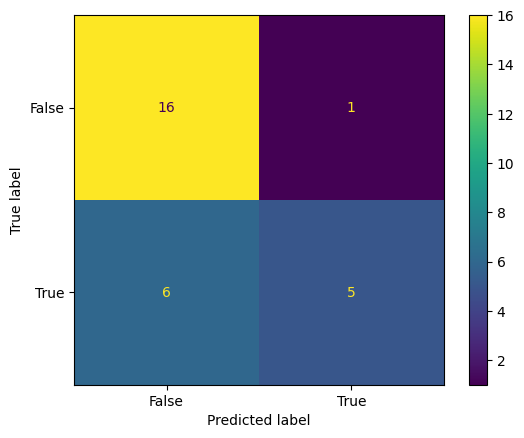

In [30]:
# confusion matrix for test predictions

display_confusion_matrix(random_search.best_estimator_, train=False)

<p style="text-align: center"><small>Fig. 9: Confusion matrix for the best classifier</small></p>


We can see that, although the model makes good predictions, it still fails to raise the "hot dog alert". 

We can further see this in the failed classifications:

In [31]:
display_model_mistmatches(random_search.best_estimator_, train=False)

,y,y_hat,x,probabilities
60,False,True,Mo's Hot Dog Plus,"[0.06980270112858956, 0.930197298871411]"
52,True,False,,"[0.6687561015925915, 0.33124389840740837]"
29,True,False,,"[0.6687561015925915, 0.33124389840740837]"
36,True,False,,"[0.6687561015925915, 0.33124389840740837]"
70,True,False,,"[0.6687561015925915, 0.33124389840740837]"
0,True,False,,"[0.6687561015925915, 0.33124389840740837]"
66,True,False,,"[0.6687561015925915, 0.33124389840740837]"


Save for the first one, which we would even classify as a hot dog stand, it still missed some of the cues we identified at the beginning, meaning this model will probably will encounter this limitations in future predictions. 

<p style="text-align: center"><small>Table 15: Mismatches for best model.</small></p>


# Discussion

We compared the performance of 4 different models (Dummy, Decision Tree, Logistic Regression, and Naive-Bayes), and Naive-Bayes had the highest accuracy, therefore, we chose Naive-Bayes to move forward with hyperparameter tuning. We used RandomizedSearchCV to identify the best hyperparameter values for Max Features and alpha, and evaluated the best model with the test set.

As we saw, there are several limitations to what a count vectorizer and a binary classification can perform. The relationships that we found within our variables are probably not linear, as there are some cases where the biases of our more intelligent classifiers, such as the Bayesian and the logistic regression, would favor into classifying something as not hotdog, when we noticed from our EDA that it was those specific cases of no name where the model should have predicted that that was hotdog stand. This makes for a model that will be particularly good at identifying the majority class, which pretty much makes it comparable to a dummy. And thus, we observed the limitations of of our current estimators.

Now, depending on the context of our problem, we may lean in favour of having a model that is really good at predicting when something is not a hotdog, versus wanting a model that is really good at predicting when something is a hotdog.

Let's say we have someone who doesn't really like hot dogs that much. We would prefer a model that probably outputs more consistently or classifies non-hot dog places as non-hot dog places where this default probably like opens up possibilities for someone looking for options that are likely not hot dog related. And it is not too terrible if hot dog place slides in given that it is the fewer of the bunch.

For that particular case, our model probably is the one fitting better into that narrative as it is consistent enough to determining or correctly classifying the null class even though if it's not as good as classifying the positive class.

Now, in the context of someone really craving a hot dog and wanting to be very sure that that is a hot dog place, then probably the best model that we trained will not fit into that description as much, since it's not particularly good into predicting a class. For that case, it would have been better to train probably a decision tree, which we saw had much higher bias into identifying the hot dog class.

A test accuracy of 0.75 shows that our model is still a work in progress, but it shows promising results from the confusion matrix, where it only has 1 FP. There are also 6 FN, as that is a byproduct of how the model learned the patterns. 

Some challenges in the data set are the size. It is a small dataset with only ~90 entries. Another challenge is the imbalance of classes. It would be ideal if each class would represent roughly 50–50% of the samples. We believe that the imbalance was not severe, so we didn’t make any adjustments. In the future, we can take the argument “class_weight” into account during hyperparameter tuning for a model that supports it.

Finally, we could also add for future iterations, or as a different research question, whether an SVM would perform better given the conditions we have mentioned. It is likely that a nonlinear model will likely fare better since we have found some instances where the natural bias of logistic regression and Naïve-Bayes have pushed the model to incorrectly classify some of the examples.

# References

- UBC Master of Data Science Program. DSCI 531: Effective use of Visual Channels– Lecture 2: Bar Chart syntax. 2025.
- UBC Master of Data Science Program. DSCI 531: Visualization for communication– Lecture 5: axis label formatting. 2025.
- W3Schools. CSS Color Names. W3Schools.com. https://www.w3schools.com/cssref/css_colors.php (accessed 21 November 2025).
- UBC Master of Data Science Program. DSCI 571: Lecture 8: Linear Models. 2025.